### • Median Consensus

Suppose the sensor network now aims to compute the **median** of the measurement data.

- Implement the **median consensus problem** using the **PDMM algorithm**.

In [90]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import matplotlib as mpl
from matplotlib.animation import PillowWriter
from IPython.display import Image
from helper import min_radius_for_sensors

Minimum required radius for connectivity with probability: 99.96000000000001 (n=50, area=100x100): 39.56 m


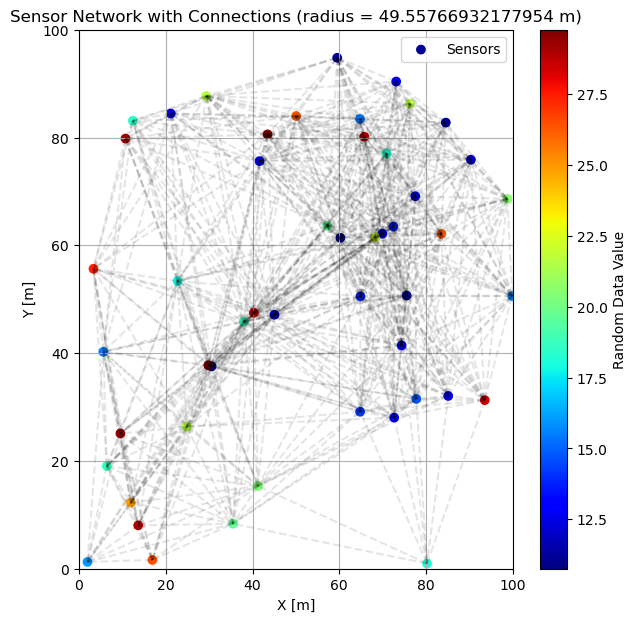

In [94]:
# Parameters
NUM_SENSORS = 50
AREA_WIDTH = 100  # meters
DIMENSION = 2

# Ensure all sensors are connected with the desired radius
radius = min_radius_for_sensors(NUM_SENSORS, DIMENSION, AREA_WIDTH) + 10 # Add some margin for faster convergence

# Generate random sensor positions again for the augmented plot
coords = np.random.uniform(low = 0, high = AREA_WIDTH, size = (NUM_SENSORS, DIMENSION))

# coords has shape (N, 2)
random_column = np.random.uniform(low=10, high=30, size=(coords.shape[0], 1))  # shape (N, 1)

# concatenate along axis=1 (columns)
coords_augmented = np.hstack((coords, random_column))  # shape (N, DIMENSION + 1)

# Compute pairwise distances
dists = np.sqrt(np.sum((coords_augmented[:, None, 0:2] - coords_augmented[None, :, 0:2])**2, axis=-1))

adjacency = (dists <= radius) & (dists > 0)

# Create figure
plt.figure(figsize=(7, 7))

# Scatter plot with color based on random data
sc = plt.scatter(x = coords[:,0], y = coords[:,1], c=coords_augmented[:,2].flatten(), cmap='jet', label='Sensors')

# Draw dashed black lines for connected sensors
for i in range(NUM_SENSORS):
    neighbors = np.where(adjacency[i])[0]
    for j in neighbors:
        if i < j:  # Avoid duplicates
            plt.plot([coords[i, 0], coords[j, 0]],
                     [coords[i, 1], coords[j, 1]],
                     'k--', alpha=0.1)

# Add colorbar
cbar = plt.colorbar(sc)
cbar.set_label('Random Data Value')

# Final plot settings
plt.xlim(0, AREA_WIDTH)
plt.ylim(0, AREA_WIDTH)
plt.title(f'Sensor Network with Connections (radius = {radius} m)')
plt.xlabel('X [m]')
plt.ylabel('Y [m]')
plt.grid(True)
plt.legend()
plt.show()

In [126]:
import numpy as np
import matplotlib.pyplot as plt

def median_consensus(adjacency, values, num_iters=100, c=1.0, verbose=False, Broadcast = True, transmission_loss = 0, min_error = 1e-2, synchronous = True):
    """
    Median consensus via PDMM 

    Parameters:
        adjacency: (N, N) boolean adjacency matrix
        values: (N,) array of private scalar values (si)
        num_iters: number of iterations
        c: convergence parameter
        verbose: whether to print diagnostics

    Returns:
        history: list of node values over time
    """
    N = len(values)
    s = values.copy()
    x = values.copy()
    history = [s.copy()]
    degrees = np.sum(adjacency, axis=1)
    real_median = np.median(s) # Calculate the true median of the initial values
    

    if np.any(degrees == 0):
        raise ValueError("Some nodes have no neighbors; graph must be connected.")

    z = {}
    for i in range(N):
        for j in range(N):
            if adjacency[i, j] > 0:
                z[(i, j)] = np.random.normal(s[i], 1)

    tx = 0

    for k in range(num_iters):
        x_new = np.zeros_like(x)

        # x update
        for i in range(N):
            neighbors = np.where(adjacency[i])[0]
            zsum = 0
            for j in neighbors:
                A = 1 if i < j else -1
                zsum += A * z[(i, j)]

            if (-1 - zsum)/(c*len(neighbors)) > s[i]:
                x_new[i] = (-1 - zsum)/(c*len(neighbors))
            elif (1 - zsum)/(c*len(neighbors)) < s[i]:
                x_new[i] = (1 - zsum)/(c*len(neighbors))
            else: 
                x_new[i] = s[i]
        if synchronous:
            active_nodes = range(N)
        else:
            active_nodes = np.random.choice(range(N), int(0.1*N))  # Randomly select 10% of nodes for update

        # z update
        z_prev = z.copy()
        for i in active_nodes:
            # With broadcast, transmission loss affects transmission of x_i to all neighbors
            if (Broadcast and transmission_loss > 0):
                    lost = np.random.choice([0,1], p=[1-transmission_loss, transmission_loss])
                    if (lost == 1):
                        tx += 1
                        continue        #break out of the loop if transmission is lost 

            for j in np.where(adjacency[i])[0]:
                # With unicast, transmission loss only affects the transmission to one neighbor              
                if Broadcast:
                    A = 1 if i < j else -1
                    z[(j, i)] = 0.5*z_prev[(j, i)] + 0.5*(z_prev[(i, j)] + 2*c*A*x_new[i])
                else:
                    if (transmission_loss > 0):
                        lost = np.random.choice([0,1], p=[1-transmission_loss, transmission_loss])
                        if (lost == 1):
                            transmission += 1
                            continue    #break out of secundar loop if transmission is lost
                    A = 1 if i < j else -1
                    z[(j, i)] = 0.5*z_prev[(j, i)] + 0.5*(z_prev[(i, j)] + 2*c*A*x_new[i])
                    tx += 1

            if (Broadcast == True):
                tx += 1


        x = x_new.copy()
        history.append(x.copy())

        err = np.linalg.norm(x - real_median)/np.linalg.norm(real_median)

        if verbose and k % 100 == 0:
            print(f"Iter {k}: max deviation from median = {err:.6f}")

        if err < min_error:
            if verbose:
                print(f"Converged at iteration {k} with max error {err:.14f}")
            break

    return k + 1, real_median, np.array(history), tx


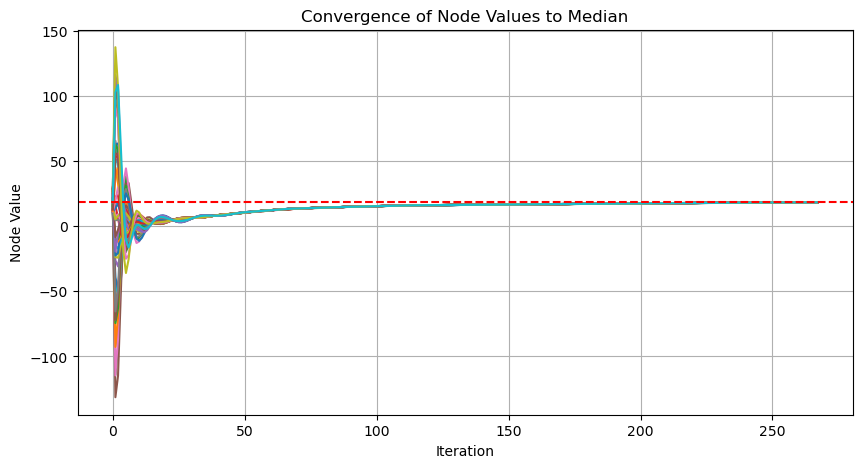

Converged in 267 iterations with median value: 18.25249184029840, final error: 0.08399065196179, normalized error: 0.00881364371845


In [127]:
#from pdmm_median_consensus import median_consensus

# Run median consensus algorithm
k, median_value, history, tx = median_consensus(adjacency, coords_augmented[:, 2], num_iters=3000, c=0.19, verbose=False, 
                                                Broadcast=True, transmission_loss=0.0, min_error=1e-2)

# Run PDMM median algorithm
#history, tx, final_values = pdmm_median(adjacency, coords_augmented[:, 2], 0.2, broadcast=True, num_iter=5000, err=1e-14)
# Plot convergence of values
plt.figure(figsize=(10, 5))
plt.plot(history, label='Node Values')
plt.axhline(y=median_value, color='r', linestyle='--', label='True Median')
plt.title('Convergence of Node Values to Median')
plt.xlabel('Iteration')
plt.ylabel('Node Value')
plt.grid()
plt.show()

#print the final error:
final_error = np.max(np.abs(history[-1] - median_value))
final_normalized_error = np.linalg.norm(history[-1] - median_value) / np.linalg.norm(median_value)
print(f"Converged in {k} iterations with median value: {median_value:.14f}, final error: {final_error:.14f}, normalized error: {final_normalized_error:.14f}")



In [ ]:
# optimize c value for the median consensus algorithm
c = np.linspace(0.01, 1, 20)
# Calculate amount of iterations for each c
iterations = []
transmissions = []
for c_value in tqdm(c):
    k, _, _, tx = median_consensus(adjacency, coords_augmented[:, 2], num_iters=2000, c=c_value, verbose=False,min_error=2e-2)
    iterations.append(k)
    transmissions.append(tx)

print("c values:", c)
print("Iterations:", iterations)
print("Transmission:", transmissions)

100%|██████████| 20/20 [01:24<00:00,  4.24s/it]

c values: [0.01       0.06210526 0.11421053 0.16631579 0.21842105 0.27052632
 0.32263158 0.37473684 0.42684211 0.47894737 0.53105263 0.58315789
 0.63526316 0.68736842 0.73947368 0.79157895 0.84368421 0.89578947
 0.94789474 1.        ]
Iterations: [2000, 2000, 2000, 2000, 2000, 2000, 478, 2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000]
Transmission: [100000, 100000, 100000, 100000, 100000, 100000, 23900, 100000, 100000, 100000, 100000, 100000, 100000, 100000, 100000, 100000, 100000, 100000, 100000, 100000]


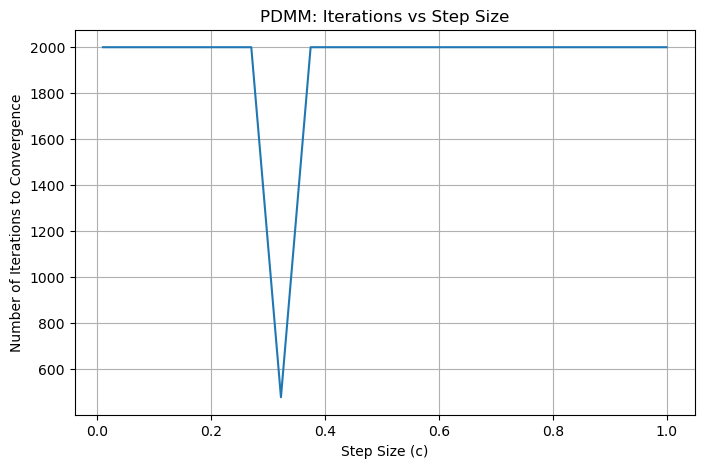

Minimum iterations: 478 for c = 0.32263157894736844


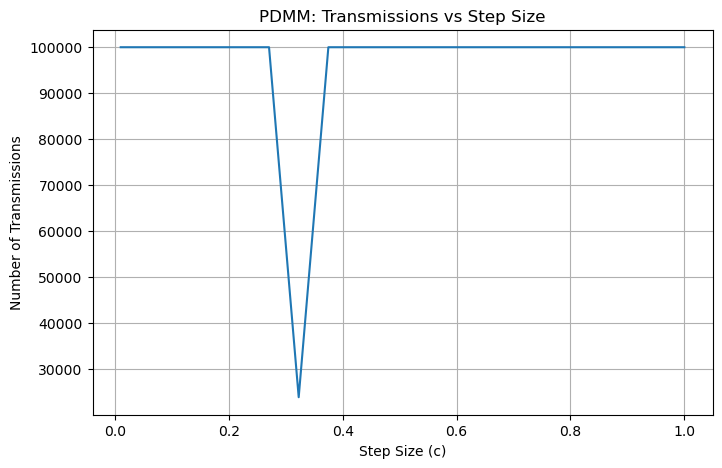

Minimum transmissions: 23900 for c = 0.32263157894736844


In [118]:
# plot in two subfigures 
# Plot iterations vs c
plt.figure(figsize=(8, 5))
plt.plot(c, iterations)
plt.xlabel('Step Size (c)')
plt.ylabel('Number of Iterations to Convergence')
plt.title('PDMM: Iterations vs Step Size')
plt.grid(True)
plt.show()

# print the c value that gives the least number of iterations
min_iterations = min(iterations)
print(f'Minimum iterations: {min_iterations} for c = {c[np.argmin(iterations)]}')

# Plot transmissions vs c
plt.figure(figsize=(8, 5))
plt.plot(c, transmissions)
plt.xlabel('Step Size (c)')
plt.ylabel('Number of Transmissions')
plt.title('PDMM: Transmissions vs Step Size')
plt.grid(True)
plt.show()

# print the c value that gives the least number of transmissions
min_transmissions = min(transmissions)
print(f'Minimum transmissions: {min_transmissions} for c = {c[np.argmin(transmissions)]}')

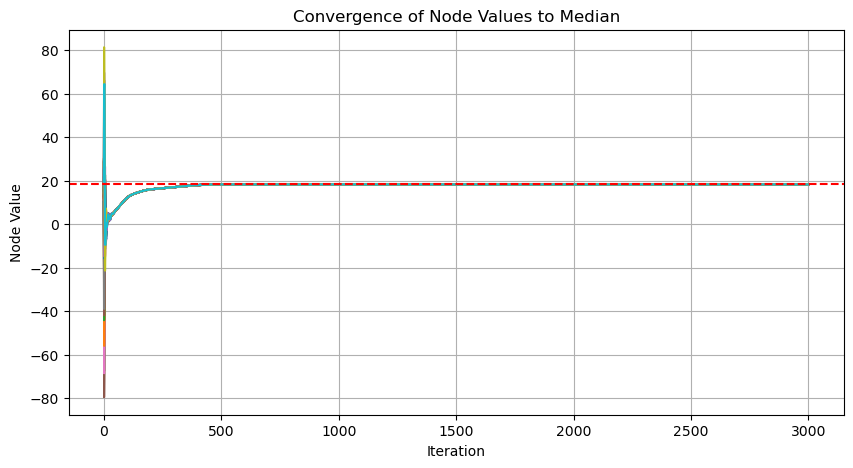

Converged in 3000 iterations with median value: 18.25249184029840, final error: 0.00161324381798, normalized error: 0.00062497529290


In [128]:
# Run median consensus algorithm
k, median_value, history, tx = median_consensus(adjacency, coords_augmented[:, 2], num_iters=3000, c=0.32, verbose=False, 
                                                Broadcast=True, transmission_loss=0.0, min_error=1e-4)

# Run PDMM median algorithm
#history, tx, final_values = pdmm_median(adjacency, coords_augmented[:, 2], 0.2, broadcast=True, num_iter=5000, err=1e-14)
# Plot convergence of values
plt.figure(figsize=(10, 5))
plt.plot(history, label='Node Values')
plt.axhline(y=median_value, color='r', linestyle='--', label='True Median')
plt.title('Convergence of Node Values to Median')
plt.xlabel('Iteration')
plt.ylabel('Node Value')
plt.grid()
plt.show()

#print the final error:
final_error = np.max(np.abs(history[-1] - median_value))
final_normalized_error = np.linalg.norm(history[-1] - median_value) / np.linalg.norm(median_value)
print(f"Converged in {k} iterations with median value: {median_value:.14f}, final error: {final_error:.14f}, normalized error: {final_normalized_error:.14f}")

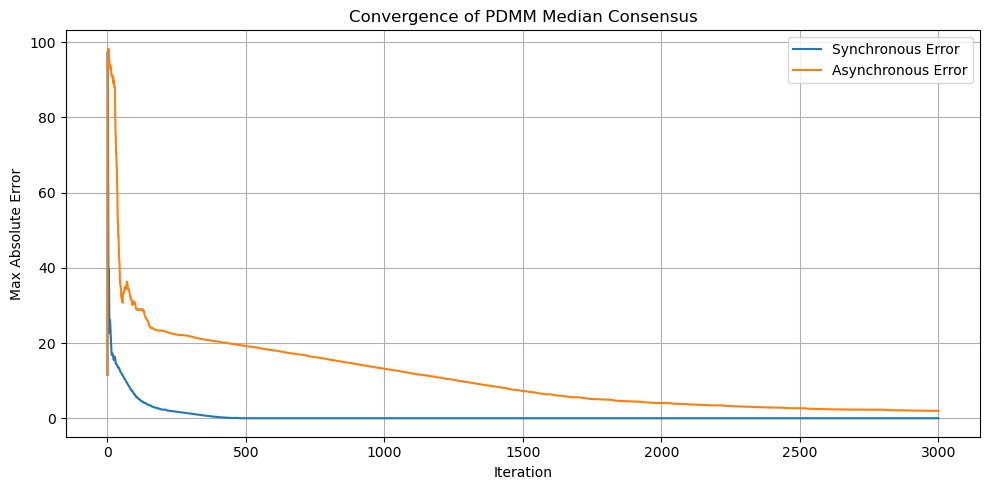

In [ ]:
# Calculate the error for synchronous and asynchronous updates with c=0.32
synchronous_transmissions = []
asynchronous_transmissions = []
k_sync, median_value_sync, history_sync, tx_sync = median_consensus(adjacency, coords_augmented[:, 2], num_iters=3000, c=0.32, verbose=False,
                                                Broadcast=True, transmission_loss=0.0, min_error=1e-4, synchronous=True)
k_async, median_value_async, history_async, tx_async = median_consensus(adjacency, coords_augmented[:, 2], num_iters=3000, c=0.32, verbose=False,
                                                Broadcast=True, transmission_loss=0.0, min_error=1e-4, synchronous=False)

n = history_sync.shape[1]  # number of nodes

# True value vector for normalization
denom_sync = np.linalg.norm(median_value_sync * np.ones(n))
denom_async = np.linalg.norm(median_value_async * np.ones(n))

# Normalized max absolute error per iteration
synchronous_error = np.linalg.norm(history_sync - median_value_sync, axis=1) / denom_sync
asynchronous_error = np.linalg.norm(history_async - median_value_async, axis=1) / denom_async

# Plot on log scale
plt.figure(figsize=(10, 5))
plt.plot(synchronous_error, label='Synchronous Error')
plt.plot(asynchronous_error, label='Asynchronous Error')
plt.yscale("log")
plt.xlabel('Iteration')
plt.ylabel('Normalized Error (log scale)')
plt.title('Normalized Convergence Error of PDMM Median Consensus')
plt.legend()
plt.grid(True, which="both", linestyle='--')
plt.tight_layout()
plt.show()